# Import libraries

In [2]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing cross validation
from surprise.model_selection import KFold

# Data Processing

Load the dataset.   
Data source: Amazon Software Reviews from https://nijianmo.github.io/amazon/index.html 

In [3]:
filepath = 'data/'
df = pd.read_csv(filepath + 'Software.csv', usecols=range(3), names=['item_id', 'user_id', 'rating'])
df.head()

,item_id,user_id,rating
0,0077613252,A240ORQ2LF9LUI,4.0
1,0077613252,A1YCCU0YRLS0FE,4.0
2,0077613252,A1BJHRQDYVAY2J,1.0
3,0077613252,APRDVZ6QBIQXT,3.0
4,0077775473,A2JZTTBSLS1QXV,5.0


Get quick stats.

In [4]:
print(df.shape)
print()
print(df.info())
print()
print(df.describe())

(459436, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459436 entries, 0 to 459435
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   item_id  459436 non-null  object 
 1   user_id  459436 non-null  object 
 2   rating   459436 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.5+ MB
None

              rating
count  459436.000000
mean        3.570175
std         1.626662
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000


Check the number of unique items.

In [5]:
df['item_id'].nunique()

21663

Check the number of unique users.

In [6]:
df['user_id'].nunique()

375147

Check for null values.

In [7]:
df.isnull().sum()

item_id    0
user_id    0
rating     0
dtype: int64

Check if there are any duplicates.

In [8]:
# Check duplicates according to item_id and user_id, i.e., when the same user rates the same item more than once
df[df.duplicated(['item_id', 'user_id'])]

,item_id,user_id,rating
2036,1600775411,A35S0B50P6PKEC,1.0
3093,B00001XDW8,AHIZUL8CP0N74,3.0
3380,B00002DDN5,A3P871LONGISQQ,5.0
4360,B00004TYCR,A1PPD5TOR6VVYV,5.0
5276,B000050ZRE,A1JZFGZEZVWQPY,5.0
...,...,...,...
424198,B003156N70,A3EQJVQF88S2XV,1.0
434317,B00004R9AU,A3HJKB1NTPH4KL,5.0
439494,B00FFZXWN2,A3OI05RGQQN33R,3.0
443074,B00J9F5FAM,AMJCW4S8KMB6Z,1.0


In [9]:
# Replace duplicate ratings of the same user on the same item with their highest rating
df = df.groupby(['item_id', 'user_id'], as_index=False).max()
len(df[df.duplicated(['item_id', 'user_id'])])

0

In [10]:
# Check number of reviews per rating
df['rating'].value_counts()

5.0    208500
1.0    100704
4.0     71990
3.0     38545
2.0     30839
Name: rating, dtype: int64

# EDA

Plot the distribution of ratings.

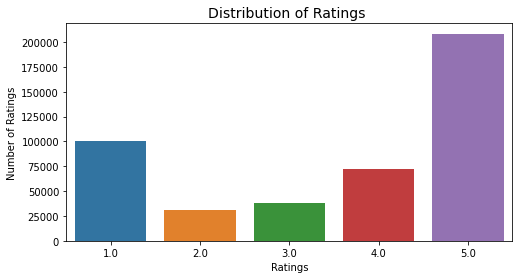

Counts of ratings
5.0    208500
1.0    100704
4.0     71990
3.0     38545
2.0     30839
Name: rating, dtype: int64


In [15]:
plt.figure(figsize = (8, 4))
sns.countplot(x = df['rating'])
plt.title("Distribution of Ratings ", fontsize = 14)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()
print('Counts of ratings')
print(df['rating'].value_counts())

Plot the distribution of user-item interactions.

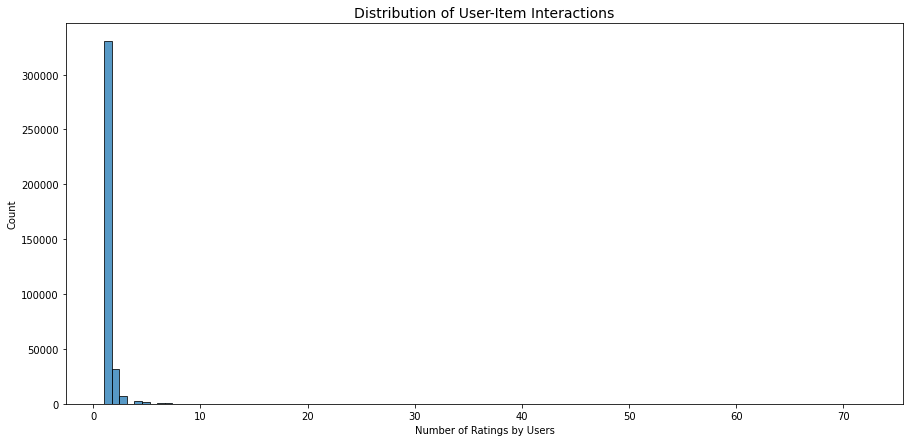

Top 10 users with the most number of ratings
user_id
A5JLAU2ARJ0BO     72
A680RUE1FDO8B     67
A225G2TFM76GYX    66
A3W4D8XOGLWUN5    66
A15S4XW3CRISZ5    64
A20DZX38KRBIT8    57
A3VL4RXCWNSR3H    51
A31N0XY2UTB25C    46
A1IU7S4HCK1XK0    39
ANGGNFE8DXGYC     39
Name: item_id, dtype: int64


In [40]:
# Get counts of user-item interactions
user_item = df.groupby('user_id').count()['item_id']

# Plot the distribution
plt.figure(figsize=(15,7))
sns.histplot(user_item, bins=100)
plt.title('Distribution of User-Item Interactions', fontsize = 14)
plt.xlabel('Number of Ratings by Users', fontsize = 10)
plt.show()

# Top 10 users with the most ratings
print('Top 10 users with the most number of ratings')
print(user_item.sort_values(ascending=False).head(10))

Create boxplot of the average rating of items.

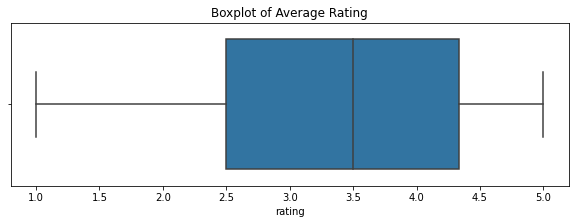

In [69]:
# Get the average rating of each item
avg_rating = df.groupby('item_id').mean().reset_index()

# Generate boxplot
plt.figure(figsize=(10, 3))
sns.boxplot(x = avg_rating['rating'])
plt.title('Boxplot of Average Rating')
plt.show()

# Popularity-based Recommendation System
A solution to the cold-start problem. This happens when a user is new to the platform or has minimal interactions with items such that the machine is not able to recommend items to the new user. 

To build this system, popular items are determined based on their average rating and the number of ratings they received.

## Build dataframe containing the (1) count and (2) average ratings of each item

In [73]:
# Get the number of ratings each item received
count_rating = df.groupby('item_id').count()['rating'].reset_index()
count_rating.columns = ['item_id', 'rating_count']

# Check that the number of items are correct
print('Number of items: ', len(count_rating))

Number of items:  21663


In [85]:
# Top items with the most number of ratings
count_rating.sort_values(by='rating_count', ascending=False).head(5)

,item_id,rating_count
19905,B00UB76290,8994
16700,B00CTTEKJW,7939
19151,B00NG7JVSQ,6395
17785,B00H9A60O4,4728
17020,B00E6LJ2SA,4046


In [86]:
# Top items with the highest average rating
avg_rating.columns = ['item_id', 'average_rating']
avg_rating.sort_values(by='average_rating', ascending=False).head(5)

,item_id,average_rating
10831,B0012W3VIS,5.0
9848,B000R1K8AE,5.0
9835,B000QV19R6,5.0
9831,B000QTZJ7O,5.0
9822,B000QJH134,5.0


In [84]:
# Create a dataframe containing the average rating and number of rating of each item
popularity_df = pd.merge(avg_rating, count_rating, on='item_id')

# Top 10 items with the most number of ratings and their average rating
popularity_df.sort_values(by='rating_count', ascending=False).head(10)

,item_id,average_rating,rating_count
19905,B00UB76290,4.231043,8994
16700,B00CTTEKJW,3.746819,7939
19151,B00NG7JVSQ,3.418765,6395
17785,B00H9A60O4,4.077411,4728
17020,B00E6LJ2SA,3.269896,4046
17241,B00EZPXYP4,4.273305,3304
20768,B015724OVG,3.938434,2745
15462,B008RA5A00,3.051506,2524
19000,B00MYXTCGY,2.826068,2271
15428,B008H3SW4I,3.093863,2216


## Create a function that returns the top n items
This function considers the minimum number of ratings an item received to be considered.

In [91]:
def get_top_items(data, n, min_ratings=100):
    recommendations = data[data['rating_count'] > min_ratings]
    recommendations = recommendations.sort_values(by='average_rating', ascending=False)
    return recommendations[:n]

## Example recommendations

In [92]:
# Top 5 items with at least 1,000 ratings
get_top_items(popularity_df, 5, 1000)

,item_id,average_rating,rating_count
17229,B00EZKNY8G,4.637658,1264
17141,B00ENFVLAQ,4.509208,1086
17244,B00EZQYC8G,4.313333,1950
17241,B00EZPXYP4,4.273305,3304
20901,B01617VQJ4,4.265533,1352


In [93]:
# Top 10 items with at least 2,000 ratings
get_top_items(popularity_df, 10, 2000)

,item_id,average_rating,rating_count
17241,B00EZPXYP4,4.273305,3304
19905,B00UB76290,4.231043,8994
20900,B01617VPUY,4.216944,2042
17785,B00H9A60O4,4.077411,4728
20914,B01637RFR4,3.967495,2092
20768,B015724OVG,3.938434,2745
16700,B00CTTEKJW,3.746819,7939
19478,B00PG8FOSY,3.623258,2081
19151,B00NG7JVSQ,3.418765,6395
17020,B00E6LJ2SA,3.269896,4046


# Collaborative Filtering Recommendation Systems
Recommendations are based on past user behavior (e.g., previous transactions or product ratings). Relationships between users and interdependencies among products are used to identify new user-item interactions (Koren et al., 2009).

## Prepare the data for training

Preliminaries:  
1. Instantiate the reader
2. Load the cleaned dataset
3. Split the data into train and test sets

In [11]:
# Instantiate the reader with the correct rating scale
reader = Reader(rating_scale=(1, 5))

# loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Define helper functions.

In [12]:
# Creating a function that outputs top n item recommendations
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating a user item interactions matrix 
    user_item_interactions_matrix = data.reset_index(drop=True).pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the item_id which user_id has not interacted yet
    for item_id in non_interacted_items:
        
        # Predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returing top n highest predicted rating item for this user

In [13]:
# Creating a function for predicting ratings for already-rated item
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the item id which user_id has interacted already
    for item_id in interacted_items:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['item_id', 'actual_rating', 'predicted_rating']) # Returing top n highest predicted rating anime for this user

## Item-based or item-item collaborative filtering recommendation system
Personalized recommendations are given by looking for items similar to those a user has rated favorably in the past. Uses the *neighborhood method, k-nearest neighbors,* to identify the relationship between items.  

### Build a baseline item-based system.

In [14]:
# Similarity measure configuration 
sim_options = {
    'name': 'msd',
    'user_based': False
}
algo_knn_item = KNNBasic(sim_options=sim_options)

# Training the algorithm on the trainset
algo_knn_item.fit(trainset)

# Predicting ratings for the testset
predictions = algo_knn_item.test(testset)

# computing RMSE on the testset
rmse_baseline_knn_item = accuracy.rmse(predictions)
print('The RMSE of the baseline item-based model is ' + str(round(rmse_baseline_knn_item, 4)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.6138
The RMSE of the baseline item-based model is 1.6138


### Get example predictions for a specific user.

In [36]:
# Top 5 recommendations for a specific user
user_id = 'A3VL4RXCWNSR3H'
recommendations = pd.DataFrame(get_recommendations(df, user_id=user_id, top_n=5, algo=algo_knn_item))
recommendations = recommendations.rename(columns={0:'item_id', 1:'predicted_rating'})
recommendations

,item_id,predicted_rating
0,0321700945,5
1,0763855553,5
2,1413313728,5
3,1935341049,5
4,2749010993,5


In [37]:
# Get the algorithms predictions for the items the specified user already rated
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df, user_id, algo_knn_item)
df_out = predicted_ratings_for_interacted_items.melt(id_vars='item_id', value_vars=['actual_rating', 'predicted_rating'])
df_out

,item_id,variable,value
0,B00004U8LD,actual_rating,5.000000
1,B00005B42L,actual_rating,5.000000
2,B00005UV59,actual_rating,5.000000
3,B000063XOB,actual_rating,5.000000
4,B0000A0S2K,actual_rating,5.000000
...,...,...,...
97,B000063CWX,predicted_rating,3.569841
98,B0002RQ442,predicted_rating,2.384268
99,B001327K8O,predicted_rating,3.569841
100,B0013OAHTG,predicted_rating,2.367658


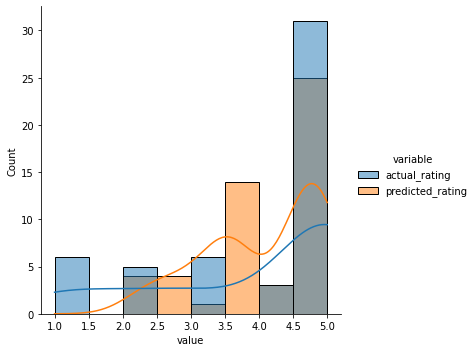

In [39]:
# Distribution plot of actual versus predicted ratings of the specified user
sns.displot(data=df_out, x='value', hue='variable', kde=True)

## User-item collaborative filtering recommendation system
Personalized recommendations are given based on latent features learned from a user's positively rated items in the past and similar users' interests. Uses a *latent factor model based on matrix factorization* to characterize both items and users through vectors of factors inferred from item rating patterns. A recommendation is derived from high correspondence between item and user factors (Koren et al., 2009).

### Build a baseline user-item system.

In [40]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# computing RMSE on the testset
rmse_baseline_svd = accuracy.rmse(predictions)
print('The RMSE of the baseline user-item model is ' + str(round(rmse_baseline_svd, 4)))

RMSE: 1.5176
The RMSE of the baseline user-item model is 1.5176


### Get example recommendations for a specific user.

In [41]:
# Top 5 recommendations for a specific user
user_id = 'A3VL4RXCWNSR3H'
recommendations = pd.DataFrame(get_recommendations(df, user_id=user_id, top_n=5, algo=algo_svd))
recommendations = recommendations.rename(columns={0:'item_id', 1:'predicted_rating'})
recommendations

,item_id,predicted_rating
0,0321700945,5
1,0615179088,5
2,0842340351,5
3,0989614026,5
4,1936207168,5


In [42]:
# Get the algorithms predictions for the items the specified user already rated
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df, user_id, algo_svd)
df_out = predicted_ratings_for_interacted_items.melt(id_vars='item_id', value_vars=['actual_rating', 'predicted_rating'])
df_out

,item_id,variable,value
0,B00004U8LD,actual_rating,5.000000
1,B00005B42L,actual_rating,5.000000
2,B00005UV59,actual_rating,5.000000
3,B000063XOB,actual_rating,5.000000
4,B0000A0S2K,actual_rating,5.000000
...,...,...,...
97,B000063CWX,predicted_rating,3.952213
98,B0002RQ442,predicted_rating,2.407772
99,B001327K8O,predicted_rating,3.250365
100,B0013OAHTG,predicted_rating,3.027737


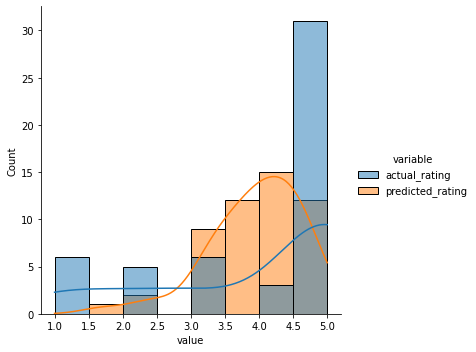

In [43]:
# Distribution plot of actual versus predicted ratings of the specified user
sns.displot(data=df_out, x='value', hue='variable', kde=True)

## Calculate precision and recall for all models

In [44]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Returns precision and recall at k metrics for each user"""

    # Mapping the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sorting user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

Precision and recall at *k*=5.

In [45]:
# Cross-validation iterator
kf = KFold(n_splits=5)
k = 5

# List of models
models = [algo_knn_item, algo_svd]

for model in models:
    print('> k={}, model={}'.format(k,model.__class__.__name__))
    p = []
    r = []
    for trainset, testset in kf.split(data):
        model.fit(trainset)
        predictions = model.test(testset, verbose=False)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

        # Precision and recall can then be averaged over all users
        p.append(sum(prec for prec in precisions.values()) / len(precisions))
        r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
    print('-----> Precision: ', round(sum(p) / len(p), 3))
    print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.612
-----> Recall:  0.617
> k=5, model=SVD
-----> Precision:  0.455
-----> Recall:  0.453
